# Part 4 - Categorically Speaking

**Notice: This notebook is a modification of [cats.ipynb and targetencode.ipynb](https://mlbook.explained.ai/notebooks/index.html) by Terence Parr and Jeremy Howard, which were used by permission of the author.**

Please use this notebook to follow along with the lectures this week. Feel free to modify the code in any way. 

There may be minor differences between the notebook seen in the lecture videos and this one. 

### Reestablish Baseline

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
import pandas as pd
from rfpimp import *
import category_encoders as ce

In [2]:
def evaluate(X, y):
    rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
    rf.fit(X, y)
    oob = rf.oob_score_
    n = rfnnodes(rf)
    h = np.median(rfmaxdepths(rf))
    print(f"OOB R^2 is {oob:.5f} using {n:,d} tree nodes with {h} median tree depth")
    return rf, oob

In [3]:
def showimp(rf, X, y):
    features = list(X.columns)
    features.remove('latitude')
    features.remove('longitude')
    features += [['latitude','longitude']]

    I = importances(rf, X, y, features=features)
    plot_importances(I, color='#4575b4')

In [4]:
rent = pd.read_csv('rent.csv')

rent_clean = rent[(rent['price'] > 1000) & (rent['price'] < 10000)]
rent_clean = rent_clean[(rent_clean['longitude'] !=0) | (rent_clean['latitude']!=0)]
rent_clean = rent_clean[(rent_clean['latitude']>40.55) &
                        (rent_clean['latitude']<40.94) &
                        (rent_clean['longitude']>-74.1) &
                        (rent_clean['longitude']<-73.67)]

In [5]:
numfeatures = ['bathrooms', 'bedrooms', 'longitude', 'latitude']

X = rent_clean[numfeatures]
y = rent_clean['price']

In [6]:
rf, oob = evaluate(X, y)

OOB R^2 is 0.86752 using 2,431,804 tree nodes with 35.0 median tree depth


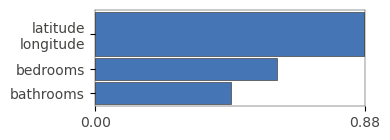

In [7]:
showimp(rf, X, y)

### Feature Engineering Continued

#### Combining Existing Features

Another thing we can do is mix features that we have in our data to create new ones. To give an example of this, let's create a new feature that combines the number of bedrooms with the number of bathrooms. What we are interested in is the ratio of bedroooms to bathrooms as this may an important predictor as well. The reasoning is that the more bedrooms you have, presumably the more people, and the more people you have can determine how long you have to wait for a bathroom to get ready, say for work or school. So, maybe the ratio of bedrooms to bathrooms would be a good feature to have. 

In [9]:
rent_clean['beds_to_baths'] = rent_clean['bedrooms'] / (rent_clean['bathrooms'] + 1)
rent_clean.head(3).T

,0,1,2
bathrooms,1.0,1.0,1.0
bedrooms,1,2,2
building_id,8579a0b0d54db803821a35a4a615e97a,b8e75fc949a6cd8225b455648a951712,cd759a988b8f23924b5a2058d5ab2b49
created,2016-06-16 05:55:27,2016-06-01 05:44:33,2016-06-14 15:19:59
description,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...
display_address,145 Borinquen Place,East 44th,East 56th Street
features,"['Dining Room', 'Pre-War', 'Laundry in Buildin...","['Doorman', 'Elevator', 'Laundry in Building',...","['Doorman', 'Elevator', 'Laundry in Building',..."
latitude,40.7108,40.7513,40.7575
listing_id,7170325,7092344,7158677
longitude,-73.9539,-73.9722,-73.9625


Now we'll see if this has any impact on our model's performance. 

In [10]:
X = rent_clean[numfeatures + ['beds_to_baths']]
y = rent_clean['price']

In [11]:
rf, oob = evaluate(X, y)

OOB R^2 is 0.86777 using 2,432,290 tree nodes with 35.0 median tree depth


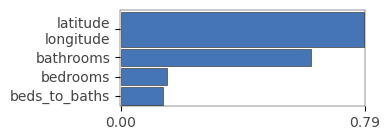

In [15]:
showimp(rf, X, y)

Maybe total number of bedrooms plus bathrooms is what is important, as opposed to having them both listed separately. 

In [14]:
rent_clean['total_rooms'] = rent_clean['bathrooms'] + rent_clean['bedrooms']
rent_clean.head(3).T

,0,1,2
bathrooms,1.0,1.0,1.0
bedrooms,1,2,2
building_id,8579a0b0d54db803821a35a4a615e97a,b8e75fc949a6cd8225b455648a951712,cd759a988b8f23924b5a2058d5ab2b49
created,2016-06-16 05:55:27,2016-06-01 05:44:33,2016-06-14 15:19:59
description,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...
display_address,145 Borinquen Place,East 44th,East 56th Street
features,"['Dining Room', 'Pre-War', 'Laundry in Buildin...","['Doorman', 'Elevator', 'Laundry in Building',...","['Doorman', 'Elevator', 'Laundry in Building',..."
latitude,40.7108,40.7513,40.7575
listing_id,7170325,7092344,7158677
longitude,-73.9539,-73.9722,-73.9625


In [15]:
X = rent_clean[['longitude', 'latitude', 'total_rooms']]
y = rent_clean['price']

In [16]:
rf, oob = evaluate(X, y)

OOB R^2 is 0.85807 using 2,399,538 tree nodes with 36.0 median tree depth


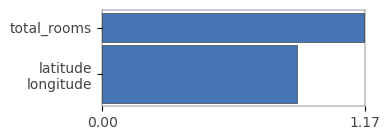

In [17]:
showimp(rf, X, y)

Or, maybe not! 

We don't have a lot of raw numeric features to play around with here, but if you did, you would want to explore other combinations and measure their impact on how well the model generalizes. 

We do have another numeric variable to consider, which is the target, `price`. And yes, combining the target with other features is as dangerous as it sounds. Let's explore that next. 

##### Target Encoding

**Any new feature that includes information about the target is referred to as *target encoding***. This is a technique that can sometimes be used to encode categorical variables. The simplest way to do this would be to use the mean of the target for each unique category value. Let's see how this would work for `building_id`. 

In [18]:
rent_clean['building_id'].nunique()

7417

In [19]:
rent_clean[['building_id', 'price']].groupby('building_id').mean()

,price
building_id,
0,3195.9321
00005cb939f9986300d987652c933e15,3399.0000
00024d77a43f0606f926e2312513845c,2000.0000
000ae4b7db298401cdae2b0ba1ea8146,2400.0000
0012f1955391bca600ec301035b97b65,3700.0000
...,...
ffdd4ab83705c9b13a9592a709414ae8,2600.0000
ffdda5554b6aa528637e1565330ea039,1795.0000
ffde4f77049b631ee532fa9e0ebdd95d,2300.0000


The code above groups all the rows according to unique building_id values and then calculates the mean of all the apartments associated with that ID. We would now use the mean prices in place of building_id. (We will ignore  the funny looking `building_id = 0`, although we would normally inverstigate that.) 

**Warning**: Using target information in our features is prone to overfitting so it is usually best to use a library like `categorical_encoders` to do this, which is what we will do now. And, to be careful, we will use a validation set, instead of the out-of-bag score.  

In [20]:
X = rent_clean[numfeatures + ['building_id']]
y = rent_clean['price']
X.head(3)

,bathrooms,bedrooms,longitude,latitude,building_id
0,1.0,1,-73.9539,40.7108,8579a0b0d54db803821a35a4a615e97a
1,1.0,2,-73.9722,40.7513,b8e75fc949a6cd8225b455648a951712
2,1.0,2,-73.9625,40.7575,cd759a988b8f23924b5a2058d5ab2b49


Now let's get a **baseline** for the original 4 numeric features but using a validation set instead of the out-of-bag score. 

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20)

X_train_orig = X_train[numfeatures]
y_train_orig = y_train.copy()
X_val_orig = X_val[numfeatures]
y_val_orig = y_val.copy()

rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rf.fit(X_train_orig, y_train_orig)

val_score_orig = rf.score(X_val_orig, y_val_orig)

print(f"{val_score_orig:4f} score {rfnnodes(rf):,d} tree nodes and {np.median(rfmaxdepths(rf))} median tree height")

0.866317 score 2,134,240 tree nodes and 35.0 median tree height


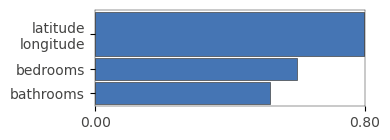

In [22]:
showimp(rf, X_train_orig, y_train_orig)

Now let's get a validation score for a model that uses the target encoded `building_id`. 

In [23]:
encoder = ce.TargetEncoder(cols=['building_id'])

encoder.fit(X_train, y_train)

X_train_enc = encoder.transform(X_train, y_train)
y_train_enc = y_train.copy()
X_val_enc = encoder.transform(X_val)
y_val_enc = y_val.copy()

In [24]:
X_train_enc.head(3)

,bathrooms,bedrooms,longitude,latitude,building_id
34579,1.0,1,-73.9952,40.7462,3689.038076
42233,1.0,3,-73.9430,40.8442,3198.088933
14571,1.0,3,-74.0088,40.7060,3198.088933


In [25]:
X_val_enc.head(3)

,bathrooms,bedrooms,longitude,latitude,building_id
28960,2.5,2,-74.0019,40.7321,3486.900309
7319,1.0,2,-73.9655,40.7609,3270.370563
21458,1.0,0,-73.8352,40.7192,3171.024595


In [28]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rf.fit(X_train_enc, y_train_enc)

val_enc_score = rf.score(X_val_enc, y_val_enc)

print(f"{val_enc_score:4f} score {rfnnodes(rf):,d} tree nodes and {np.median(rfmaxdepths(rf))} median tree height")

0.818086 score 2,323,622 tree nodes and 36.0 median tree height


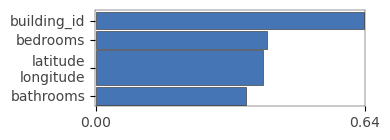

In [29]:
showimp(rf, X_train_enc, y_train_enc)

While the validation scores are similar, the median tree height has increased and now the model feels that the target encoded `building_id` feature is, by a substantial margin, the most important feature. **This is suspicious and indicates that the model is overfitting**, that is, attaching too much importance to this feature as opposed to the other features that we know are important; most likely a result of using the target information. 

It may not be useful here, but it is good to know this technique and how to properly apply it. 

##### Exercise

Try *target encoding* the `manager_id` and `display_address` features and comparing the results to the baseline. 

In [30]:
X = rent_clean[numfeatures + ['manager_id']]
y = rent_clean['price']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20)

encoder = ce.TargetEncoder(cols=['manager_id'])

encoder.fit(X_train, y_train)

X_train_enc = encoder.transform(X_train, y_train)
y_train_enc = y_train.copy()
X_val_enc = encoder.transform(X_val)
y_val_enc = y_val.copy()

In [31]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rf.fit(X_train_enc, y_train_enc)

val_enc_score = rf.score(X_val_enc, y_val_enc)

print(f"{val_enc_score:4f} score {rfnnodes(rf):,d} tree nodes and {np.median(rfmaxdepths(rf))} median tree height")

0.832852 score 3,912,596 tree nodes and 39.0 median tree height


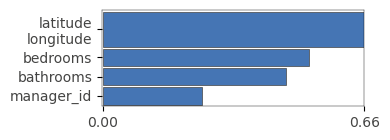

In [32]:
showimp(rf, X_train_enc, y_train_enc)

#### Display address

In [33]:
rent_clean['display_address'].head()

0    145 Borinquen Place
1              East 44th
2       East 56th Street
3    Metropolitan Avenue
4       East 34th Street
Name: display_address, dtype: object

In [34]:
rent_clean['display_address'].nunique()

8691

In [35]:
X = rent_clean[numfeatures + ['display_address']]
y = rent_clean['price']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20)

encoder = ce.TargetEncoder(cols=['display_address'])

encoder.fit(X_train, y_train)

X_train_enc = encoder.transform(X_train, y_train)
y_train_enc = y_train.copy()
X_val_enc = encoder.transform(X_val)
y_val_enc = y_val.copy()

In [36]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rf.fit(X_train_enc, y_train_enc)

val_enc_score = rf.score(X_val_enc, y_val_enc)

print(f"{val_enc_score:4f} score {rfnnodes(rf):,d} tree nodes and {np.median(rfmaxdepths(rf))} median tree height")

0.827429 score 2,636,136 tree nodes and 37.0 median tree height


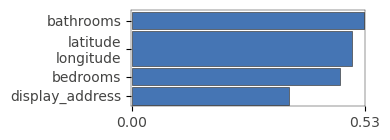

In [37]:
showimp(rf, X_train_enc, y_train_enc)

#### Adding Features Using Other Data

After you have explored all you can do with the original raw data, it may be worthwhile to include information from other sources. For apartments in New York City, as is the case in most cities, adding a *neighbourhood* feature may have predictive power. While we have `latitude` and `longitude` different neighbourhoods may command different prices for an apartment with otherwise similar features because some areas of the city are more trendy than others; and, as a result, people may be willing to pay more to live there. (See [Chapter 6](https://mlbook.explained.ai/catvars.html#sec:6.6) for more details.)

We can first use something like maps.google.com (similar) to estimate the latitude and longitude of some neighbourhoods in New York City and store that information in a dictionary. 

In [38]:
hoods = {
    "hells" : [40.7622, -73.9924],
    "astoria" : [40.7796684, -73.9215888],
    "Evillage" : [40.723163774, -73.984829394],
    "Wvillage" : [40.73578, -74.00357],
    "LowerEast" : [40.715033, -73.9842724],
    "UpperEast" : [40.768163594, -73.959329496],
    "ParkSlope" : [40.672404, -73.977063],
    "Prospect Park" : [40.93704, -74.17431],
    "Crown Heights" : [40.657830702, -73.940162906],
    "financial" : [40.703830518, -74.005666644],
    "brooklynheights" : [40.7022621909, -73.9871760513],
    "gowanus" : [40.673, -73.997]
}

We now want to create a new feature for each neighbourhood that calculates the, appropriately named, *Manhattan distance* from each apartment to that neighbourhood. We use Manhattan distance as that could be considered more connected to walking distance from the apartment to the neighbourhood in question. 


<img src="manhattan_dist.jpg" width=600 align="center">

In [39]:
hoods.items()

dict_items([('hells', [40.7622, -73.9924]), ('astoria', [40.7796684, -73.9215888]), ('Evillage', [40.723163774, -73.984829394]), ('Wvillage', [40.73578, -74.00357]), ('LowerEast', [40.715033, -73.9842724]), ('UpperEast', [40.768163594, -73.959329496]), ('ParkSlope', [40.672404, -73.977063]), ('Prospect Park', [40.93704, -74.17431]), ('Crown Heights', [40.657830702, -73.940162906]), ('financial', [40.703830518, -74.005666644]), ('brooklynheights', [40.7022621909, -73.9871760513]), ('gowanus', [40.673, -73.997])])

In [40]:
for hood, loc in hoods.items():
    rent_clean[hood] = np.abs(rent_clean['latitude'] - loc[0]) + np.abs(rent_clean['longitude'] - loc[1])

In [41]:
list(hoods.keys())

['hells',
 'astoria',
 'Evillage',
 'Wvillage',
 'LowerEast',
 'UpperEast',
 'ParkSlope',
 'Prospect Park',
 'Crown Heights',
 'financial',
 'brooklynheights',
 'gowanus']

In [42]:
rent_clean.head(2)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,...,Evillage,Wvillage,LowerEast,UpperEast,ParkSlope,Prospect Park,Crown Heights,financial,brooklynheights,gowanus
0,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"['Dining Room', 'Pre-War', 'Laundry in Buildin...",40.7108,7170325,-73.9539,...,0.043293,0.07465,0.034605,0.062793,0.061559,0.44665,0.066706,0.058736,0.041814,0.0809
1,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"['Doorman', 'Elevator', 'Laundry in Building',...",40.7513,7092344,-73.9722,...,0.040766,0.04689,0.048339,0.029734,0.083759,0.38785,0.125506,0.080936,0.064014,0.1031


In [43]:
rent_clean[numfeatures + list(hoods.keys())].head()

,bathrooms,bedrooms,longitude,latitude,hells,astoria,Evillage,Wvillage,LowerEast,UpperEast,ParkSlope,Prospect Park,Crown Heights,financial,brooklynheights,gowanus
0,1.0,1,-73.9539,40.7108,0.0899,0.10118,0.043293,0.07465,0.034605,0.062793,0.061559,0.44665,0.066706,0.058736,0.041814,0.0809
1,1.0,2,-73.9722,40.7513,0.0311,0.07898,0.040766,0.04689,0.048339,0.029734,0.083759,0.38785,0.125506,0.080936,0.064014,0.1031
2,1.0,2,-73.9625,40.7575,0.0346,0.06308,0.056666,0.06279,0.064239,0.013834,0.099659,0.39135,0.122006,0.096836,0.079914,0.1190
3,1.5,3,-73.9425,40.7145,0.0976,0.08608,0.050993,0.08235,0.042305,0.070493,0.076659,0.45435,0.059006,0.073836,0.056914,0.0960
4,1.0,0,-73.9743,40.7439,0.0364,0.08848,0.031266,0.03739,0.038839,0.039234,0.074259,0.39315,0.120206,0.071436,0.054514,0.0936


Let's check to see if this helps out our model at all. 

In [44]:
X = rent_clean[numfeatures + list(hoods.keys())]
y = rent_clean['price']

In [45]:
rf, oob = evaluate(X, y)

OOB R^2 is 0.87245 using 2,412,342 tree nodes with 43.0 median tree depth


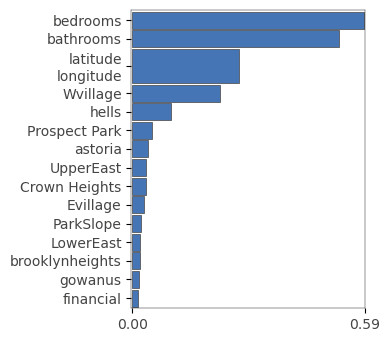

In [46]:
showimp(rf, X, y)

We could probably remove the original `latitude` and `longitude` columns as there is now enough *location* information contained within the neghbourhood data, but we'll leave them all in here. 